# Cluster analysis

## Imports, preparations, global variables and functions

In [1]:
from glob import glob
from collections import namedtuple
import pandas as pd
import numpy as np
from scipy.stats import kstest
import napari
from imodmodel import ImodModel
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
from plotting_tools import *
set_paper()

def sample_to_cell_line(s) -> str:
    return {
        "Rab11wt": "A549-Rab11wt",
        "A549wt": "A549wt",
        "Rab11dn": "A549-Rab11dn",
    }[s.split("_")[1]]

def load_sample(path) -> dict:
    model_by_glob = lambda s: glob(f"models/{path}/mtk/{s}")[0]
    return dict(
        name=path,
        cell_line=sample_to_cell_line(path),
        vRNP_model_path=model_by_glob("*_mtk_vRNPs.mod"),
        HA_model_path=model_by_glob("*_mtk_HA.mod"),
        vRNP_model_path_shifted=model_by_glob("*_mtk_vRNPs_shifted.mod"),
        HA_model_path_shifted=model_by_glob("*_mtk_HA_shifted.mod"),
    )

def row_by_contour(d, sample: str, contour: int):
    return data[data["sample"].str.fullmatch(sample) & (data["vRNP contour"] == contour)]

samples = [
    load_sample(s) for s in [
        "PR8_Rab11wt_210503_TS_01",
        "PR8_Rab11wt_210120_TS_02",
        "PR8_A549wt_211220_TS_16",
        "PR8_A549wt_220408_TS_07",
        'PR8_Rab11dn_211201_TS_06',
        'PR8_Rab11dn_220815_TS_10',
        'PR8_Rab11dn_220815_TS_07',
    ]]

## Read data into one big dataframe

vRNP_diameter = 14
min_cluster_size = 3
cluster_distance_threshold = 4

data = pd.read_csv("nearest_neighbor_analysis.csv")
data.head()

,sample,cell_line,vRNP coords,vRNP contour,vRNP vRNP distance [nm],Closest vRNP index,vRNP membrane distance [nm],vRNP coords shifted,vRNP vRNP distance shifted [nm],Closest vRNP index shifted,...,Cluster size,Cluster ID > 3,Color_tab20,Color_hsv,Cluster ID shifted,Cluster size shifted,Cluster ID shifted > 3,Color_tab20 shifted,Color_hsv shifted,Tomogram #
0,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,[[ 965. 3642. 233.50003052]\n...,1,0.909301,424,15.347978,[[ 525.13244629 1762.41137695 183. ]\n...,0.000000,214,...,13,0,"(0.12156862745098039, 0.4666666666666667, 0.70...","(1.0, 0.0, 0.0, 1.0)",0,4,0,"(0.12156862745098039, 0.4666666666666667, 0.70...","(1.0, 0.0, 0.0, 1.0)",2
1,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,[[ 920.23278809 3714.22607422 281.85873413]\n...,2,1.622792,5,31.295976,[[1479.47265625 5577.79150391 251.99998474]\n...,7.515219,128,...,13,0,"(0.12156862745098039, 0.4666666666666667, 0.70...","(1.0, 0.0, 0.0, 1.0)",1,1,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],2
2,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,[[3122.00024414 2304. 225.50003052]\n...,3,3.851390,3,15.994725,[[2083.77563477 1172.28222656 260. ]\n...,2.533298,69,...,2,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],2,2,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],2
3,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,[[3108. 2442. 225.50003052]\n...,4,3.851390,2,14.652900,[[1700.15112305 843.28527832 323. ]\n...,7.341125,239,...,2,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],3,1,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],2
4,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,[[2848. 2106. 225.50003052]\n...,5,4.752192,493,11.538369,[[1780.92553711 4328.66113281 -21.00001526]\n...,15.381139,213,...,1,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],4,1,-1,[0.5 0.5 0.5 1. ],[0.5 0.5 0.5 1. ],2


## Significance tests and such

In [2]:
vRNP_vRNP = lambda cell_line: data[data["cell_line"] == cell_line]["vRNP vRNP distance [nm]"]
vRNP_memb = lambda cell_line: data[data["cell_line"] == cell_line]["vRNP membrane distance [nm]"]

for c1, c2 in [
    ("A549wt", "A549-Rab11wt"),
    ("A549wt", "A549-Rab11dn"),
    ("A549-Rab11wt", "A549-Rab11dn"),
]:
    p_vRNP_vRNP = kstest(vRNP_vRNP(c1), vRNP_vRNP(c2)).pvalue
    p_vRNP_memb = kstest(vRNP_memb(c1), vRNP_memb(c2)).pvalue
    print(f"{c1} ::: {c2}\nvRNP vRNP: {p_vRNP_vRNP:.2g}\nvRNP memb: {p_vRNP_memb:.2g}\n")

A549wt ::: A549-Rab11wt
vRNP vRNP: 0.021
vRNP memb: 0.19

A549wt ::: A549-Rab11dn
vRNP vRNP: 4.9e-07
vRNP memb: 0.083

A549-Rab11wt ::: A549-Rab11dn
vRNP vRNP: 9.8e-08
vRNP memb: 0.0017



In [3]:
vRNP_vRNP = lambda cell_line: data[data["cell_line"] == cell_line]["vRNP vRNP distance shifted [nm]"]
vRNP_memb = lambda cell_line: data[data["cell_line"] == cell_line]["vRNP membrane distance shifted [nm]"]

for c1, c2 in [
    ("A549wt", "A549-Rab11wt"),
    ("A549wt", "A549-Rab11dn"),
    ("A549-Rab11wt", "A549-Rab11dn"),
]:
    p_vRNP_vRNP = kstest(vRNP_vRNP(c1), vRNP_vRNP(c2)).pvalue
    p_vRNP_memb = kstest(vRNP_memb(c1), vRNP_memb(c2)).pvalue
    print(f"{c1} ::: {c2}\nvRNP vRNP: {p_vRNP_vRNP:.2g}\nvRNP memb: {p_vRNP_memb:.2g}\n")

A549wt ::: A549-Rab11wt
vRNP vRNP: 0.59
vRNP memb: 0.0031

A549wt ::: A549-Rab11dn
vRNP vRNP: 2.1e-16
vRNP memb: 0.00061

A549-Rab11wt ::: A549-Rab11dn
vRNP vRNP: 1.6e-17
vRNP memb: 2.6e-09



In [4]:
data["test"] = data["vRNP membrane distance [nm]"] < 100
data.groupby("cell_line")["test"].value_counts(normalize=True) * 100

cell_line     test 
A549-Rab11dn  True     78.431373
              False    21.568627
A549-Rab11wt  True     99.353796
              False     0.646204
A549wt        True     96.261682
              False     3.738318
Name: test, dtype: float64

## Plotting nearest neighbor distances

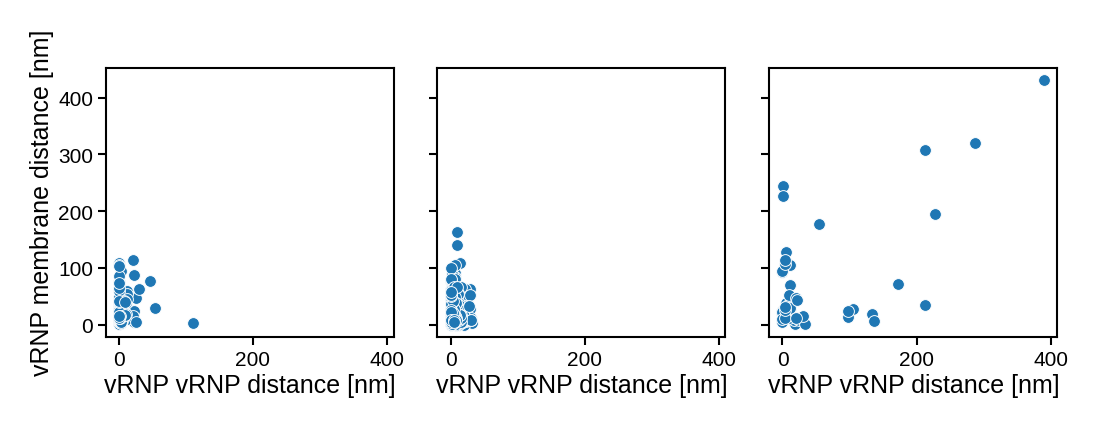

In [5]:
%matplotlib inline
sns.set_palette("tab10")

cell_line_order = ["A549wt", "A549-Rab11wt", "A549-Rab11dn"]

width = 90

fig, axes = plt.subplots(ncols=3, figsize=cm2in(width/10, width/30), sharex=True, sharey=True)

for col, cell_line in enumerate(cell_line_order):
    ax_data = data[data["cell_line"].str.fullmatch(cell_line)]
    sns.scatterplot(
        data=ax_data,
        y='vRNP membrane distance [nm]',
        x='vRNP vRNP distance [nm]',
        # hue="Tomogram #",
        ax=axes[col],
        s=8,
        # marker="+",
        # palette=sns.color_palette()[:len(ax_data["Tomogram #"].unique())],
        legend=cell_line == cell_line_order[-1],
    )

# Annotate single points
if False:
    for sample, contour, color, ax in [
        # A549wt
        ("PR8_A549wt_211220_TS_16", 1, "red", axes[0]),
        ("PR8_A549wt_211220_TS_16", 13, "blue", axes[0]),
        ("PR8_A549wt_211220_TS_16", 36, "blue", axes[0]),
        ("PR8_A549wt_211220_TS_16", 48, "blue", axes[0]),
        ("PR8_A549wt_211220_TS_16", 57, "blue", axes[0]),
        # A549-Rab11wt
        ("PR8_Rab11wt_210120_TS_02", 104, "blue", axes[1]),
    ]:
        row = row_by_contour(data, sample, contour)
        ax.plot(
            row["vRNP vRNP distance [nm]"],
            row["vRNP membrane distance [nm]"],
            marker="+",
            color=color,
            markersize=10,
            markeredgewidth=0.5,
        )
        ax.text(
            row["vRNP vRNP distance [nm]"],
            row["vRNP membrane distance [nm]"],
            f"{sample} : {contour}",
            size=4,
        )
plt.savefig("scatter_split.svg")

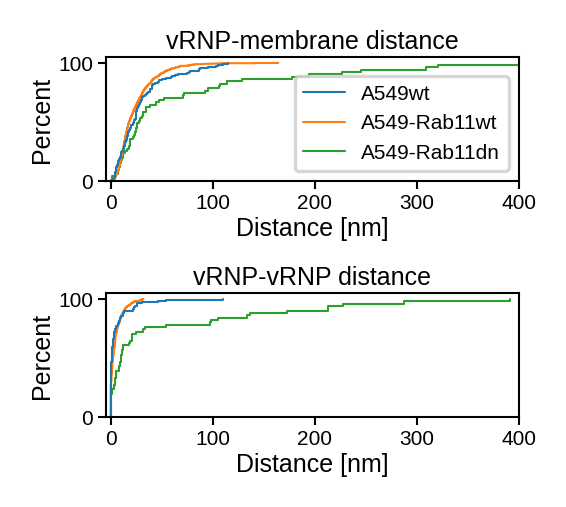

In [6]:
%matplotlib inline
sns.set_palette("tab10")

cell_line_order = ["A549wt", "A549-Rab11wt", "A549-Rab11dn"]

fig, axes = plt.subplots(nrows=2, figsize=mm2in(45, 40), sharey=True)

sns.ecdfplot(
    data=data,
    x='vRNP membrane distance [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    stat="percent",
    ax=axes[0],
)
axes[0].set_title("vRNP-membrane distance")

sns.ecdfplot(
    data=data,
    x='vRNP vRNP distance [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    stat="percent",
    ax=axes[1],
    legend=False,
)
axes[1].set_title("vRNP-vRNP distance")

sns.move_legend(axes[0], loc="best", title="")
for ax in axes:
    ax.set_xlabel("Distance [nm]")
    ax.set_xlim(-5, 400)

plt.savefig("ecdf.svg")

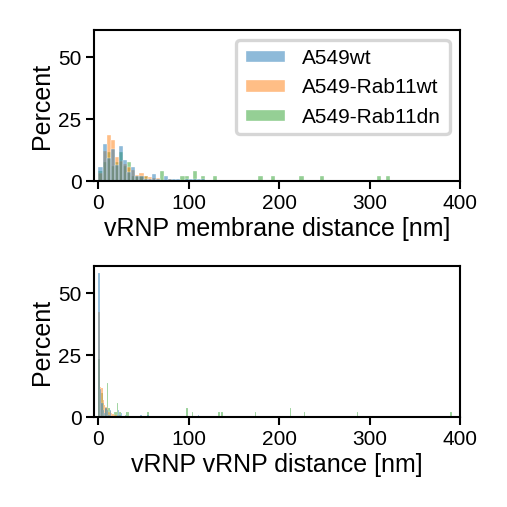

In [7]:
%matplotlib inline
set_paper()
sns.set_palette("tab10")

cell_line_order = ["A549wt", "A549-Rab11wt", "A549-Rab11dn"]

fig, axes = plt.subplots(nrows=2, figsize=cm2in(4, 4), sharey=True)

sns.histplot(
    data=data,
    x='vRNP membrane distance [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    stat="percent",
    ax=axes[0],
    common_norm=False,
)

sns.histplot(
    data=data,
    x='vRNP vRNP distance [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    stat="percent",
    ax=axes[1],
    legend=False,
    common_norm=False,
)
sns.move_legend(axes[0], loc="best", title="")
for ax in axes:
    ax.set_xlim(-5, 400)

plt.savefig("hist.svg")

# Cluster membrane distance

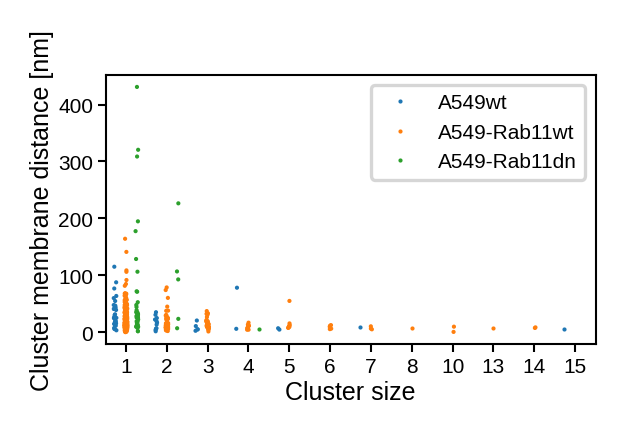

In [8]:
df = data.groupby(['sample', 'Cluster ID'])['vRNP membrane distance [nm]'].agg('min').reset_index()
def get_cluster_info(row):
    sample_data = data[data["sample"].str.fullmatch(row["sample"])]
    return sample_data[sample_data["Cluster ID"] == row["Cluster ID"]][["cell_line", "Cluster size"]].iloc[0]
df[["cell_line", "Cluster size"]] = df.apply(get_cluster_info, axis=1)

fig, ax = plt.subplots(figsize=mm2in(50, 30))

sns.stripplot(
    data=df,
    y="vRNP membrane distance [nm]",
    x="Cluster size",
    hue="cell_line",
    hue_order=["A549wt", "A549-Rab11wt", "A549-Rab11dn"],
    s=1,
    dodge=True,
    ax=ax,
)
ax.set_ylabel("Cluster membrane distance [nm]")
sns.move_legend(ax, loc="best", title="")
fig.savefig("cluster_membrane_distance.svg")

## Randomly shifted vRNPs

/tmp/ipykernel_9587/3599566218.py:35: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  plt.tight_layout()


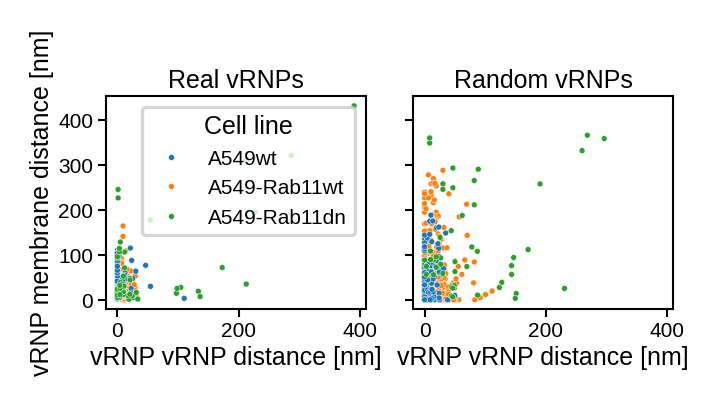

In [9]:
%matplotlib inline

cell_line_order = ["A549wt", "A549-Rab11wt", "A549-Rab11dn"]

fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=cm2in(6, 3), sharex=True, sharey=True)

ax1.set_title('Real vRNPs')
sns.scatterplot(
    data=data,
    y='vRNP membrane distance [nm]',
    x='vRNP vRNP distance [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    ax=ax1,
    s=2,
    legend=True,
)

ax2.set_title('Random vRNPs')
sns.scatterplot(
    data=data,
    y='vRNP membrane distance shifted [nm]',
    x='vRNP vRNP distance shifted [nm]',
    hue="cell_line",
    hue_order=cell_line_order,
    ax=ax2,
    s=2,
    legend=False,
)

ax1.legend().set_title('Cell line')
ax2.set_xlabel(ax1.get_xlabel())
ax2.set_ylabel(ax1.get_ylabel())

plt.tight_layout()

## Cluster analysis

In [10]:
cluster_size_data = pd.read_csv("cluster_size_analysis.csv")
cluster_size_data.head()

,sample,cell_line,matrix,threshold,cluster_id,cluster_size
0,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,segmentation,0,0,1
1,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,segmentation,0,1,1
2,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,segmentation,0,2,1
3,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,segmentation,0,3,1
4,PR8_Rab11wt_210503_TS_01,A549-Rab11wt,segmentation,0,4,1


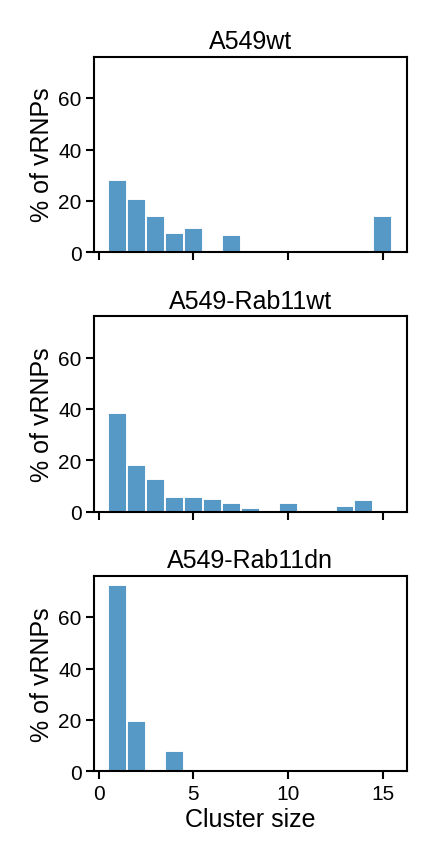

In [11]:
%matplotlib inline

fig, axes = plt.subplots(nrows=3, figsize=mm2in(34, 70), sharex=True, sharey=True)
cluster_distance_threshold = 4
thedata = lambda cell_line: cluster_size_data[
    (cluster_size_data.cluster_size > 0)
    & (cluster_size_data.threshold == cluster_distance_threshold)
    & (cluster_size_data.matrix == "segmentation")
    & (cluster_size_data.cell_line.str.fullmatch(cell_line))
]

for ax, cell_line in [
    (axes[0], "A549wt"),
    (axes[1], "A549-Rab11wt"),
    (axes[2], "A549-Rab11dn"),
]:
    sns.histplot(
        data=thedata(cell_line),
        x="cluster_size",
        stat="percent",
        discrete=True,
        ax=ax,
    )
    ax.set_title(cell_line)
    ax.set_xlabel("Cluster size")
    ax.set_ylabel("% of vRNPs")
fig.savefig("cluster_size_hist.svg")

In [12]:
print('Histplot raw data')
for cell in ['A549wt', 'A549-Rab11wt', 'A549-Rab11dn']:
    print(cell)
    print(thedata(cell)["cluster_size"].value_counts(normalize=True).sort_index() * 100)
    print('\n\n')

Histplot raw data
A549wt
1     28.037383
2     20.560748
3     14.018692
4      7.476636
5      9.345794
7      6.542056
15    14.018692
Name: cluster_size, dtype: float64



A549-Rab11wt
1     38.449111
2     18.093700
3     12.600969
4      5.815832
5      5.654281
6      4.846527
7      3.392569
8      1.292407
10     3.231018
13     2.100162
14     4.523425
Name: cluster_size, dtype: float64



A549-Rab11dn
1    72.549020
2    19.607843
4     7.843137
Name: cluster_size, dtype: float64





/opt/anaconda3/envs/mtk_nearest_neighbor/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


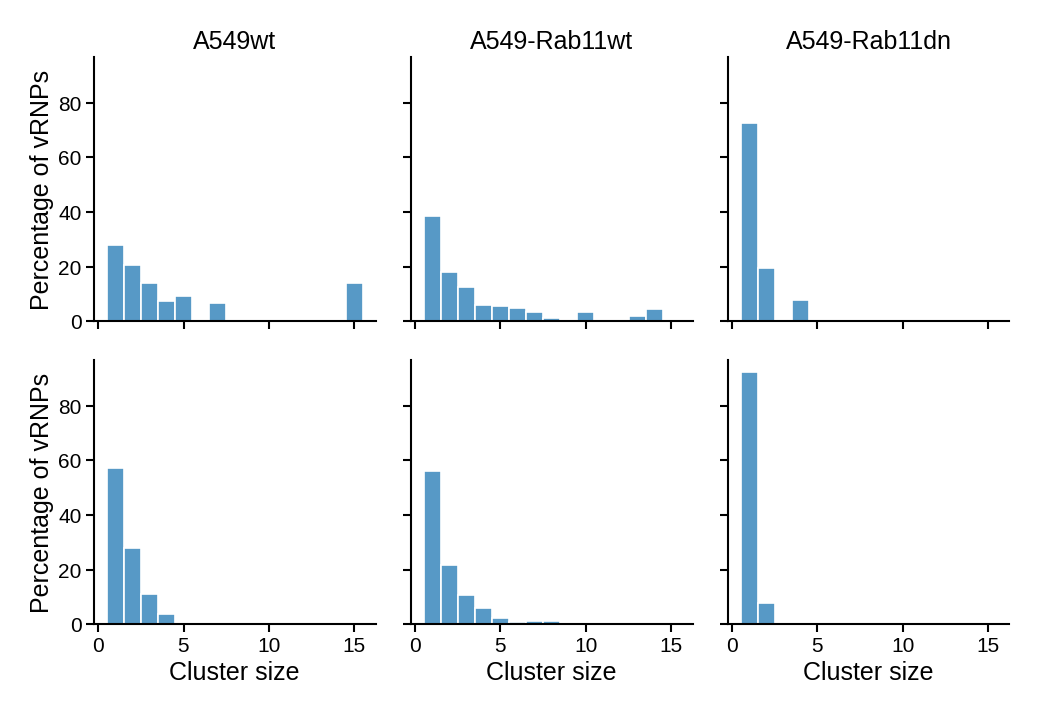

In [13]:
%matplotlib inline

g = sns.FacetGrid(
    data=cluster_size_data[
        (cluster_size_data.cluster_size > 0)
        & (cluster_size_data.threshold == cluster_distance_threshold)
    ],
    row="matrix",
    col="cell_line",
    col_order=cell_line_order,
    margin_titles=True,
    height=cm2in(3),
)

g.map_dataframe(
    sns.histplot,
    x="cluster_size",
    stat="percent",
    discrete=True,
)

g.set_axis_labels(
    "Cluster size",
    "Percentage of vRNPs"
)
g.set_titles(
    template="{col_name} {row_name}",
    row_template="",
    col_template="{col_name}",
)
g.savefig("cluster_size_hist_all.svg")

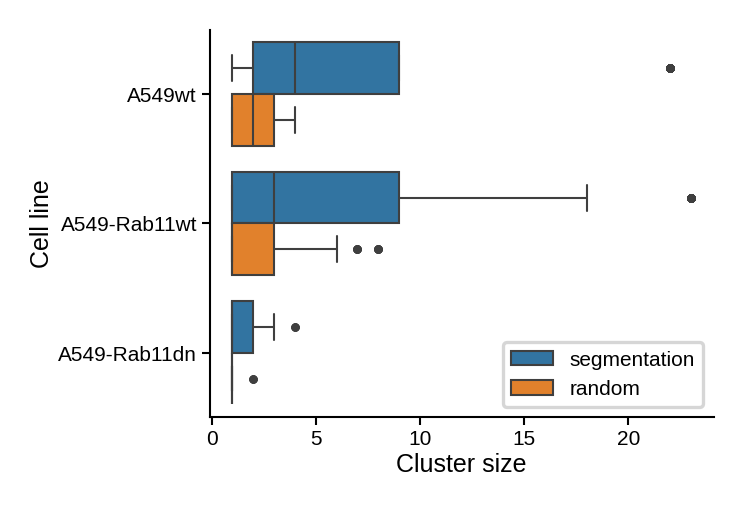

In [14]:
%matplotlib inline
fig, ax = plt.subplots(figsize=cm2in(6, 4))

g = sns.boxplot(
    data=cluster_size_data[
        (cluster_size_data.cluster_size > -1)
        & (cluster_size_data.threshold == 6)
    ],
    x="cluster_size",
    y="cell_line",
    order=cell_line_order,
    hue="matrix",
    ax=ax,
    linewidth=0.5,
    fliersize=1,
)
sns.despine(top=True, right=True)
ax.set_ylabel("Cell line")
ax.set_xlabel("Cluster size")
ax.get_legend().set_title("")
fig.savefig("cluster_size_box.svg")

/opt/anaconda3/envs/mtk_nearest_neighbor/lib/python3.10/site-packages/seaborn/axisgrid.py:123: UserWarning: This figure was using constrained_layout, but that is incompatible with subplots_adjust and/or tight_layout; disabling constrained_layout.
  self._figure.tight_layout(*args, **kwargs)


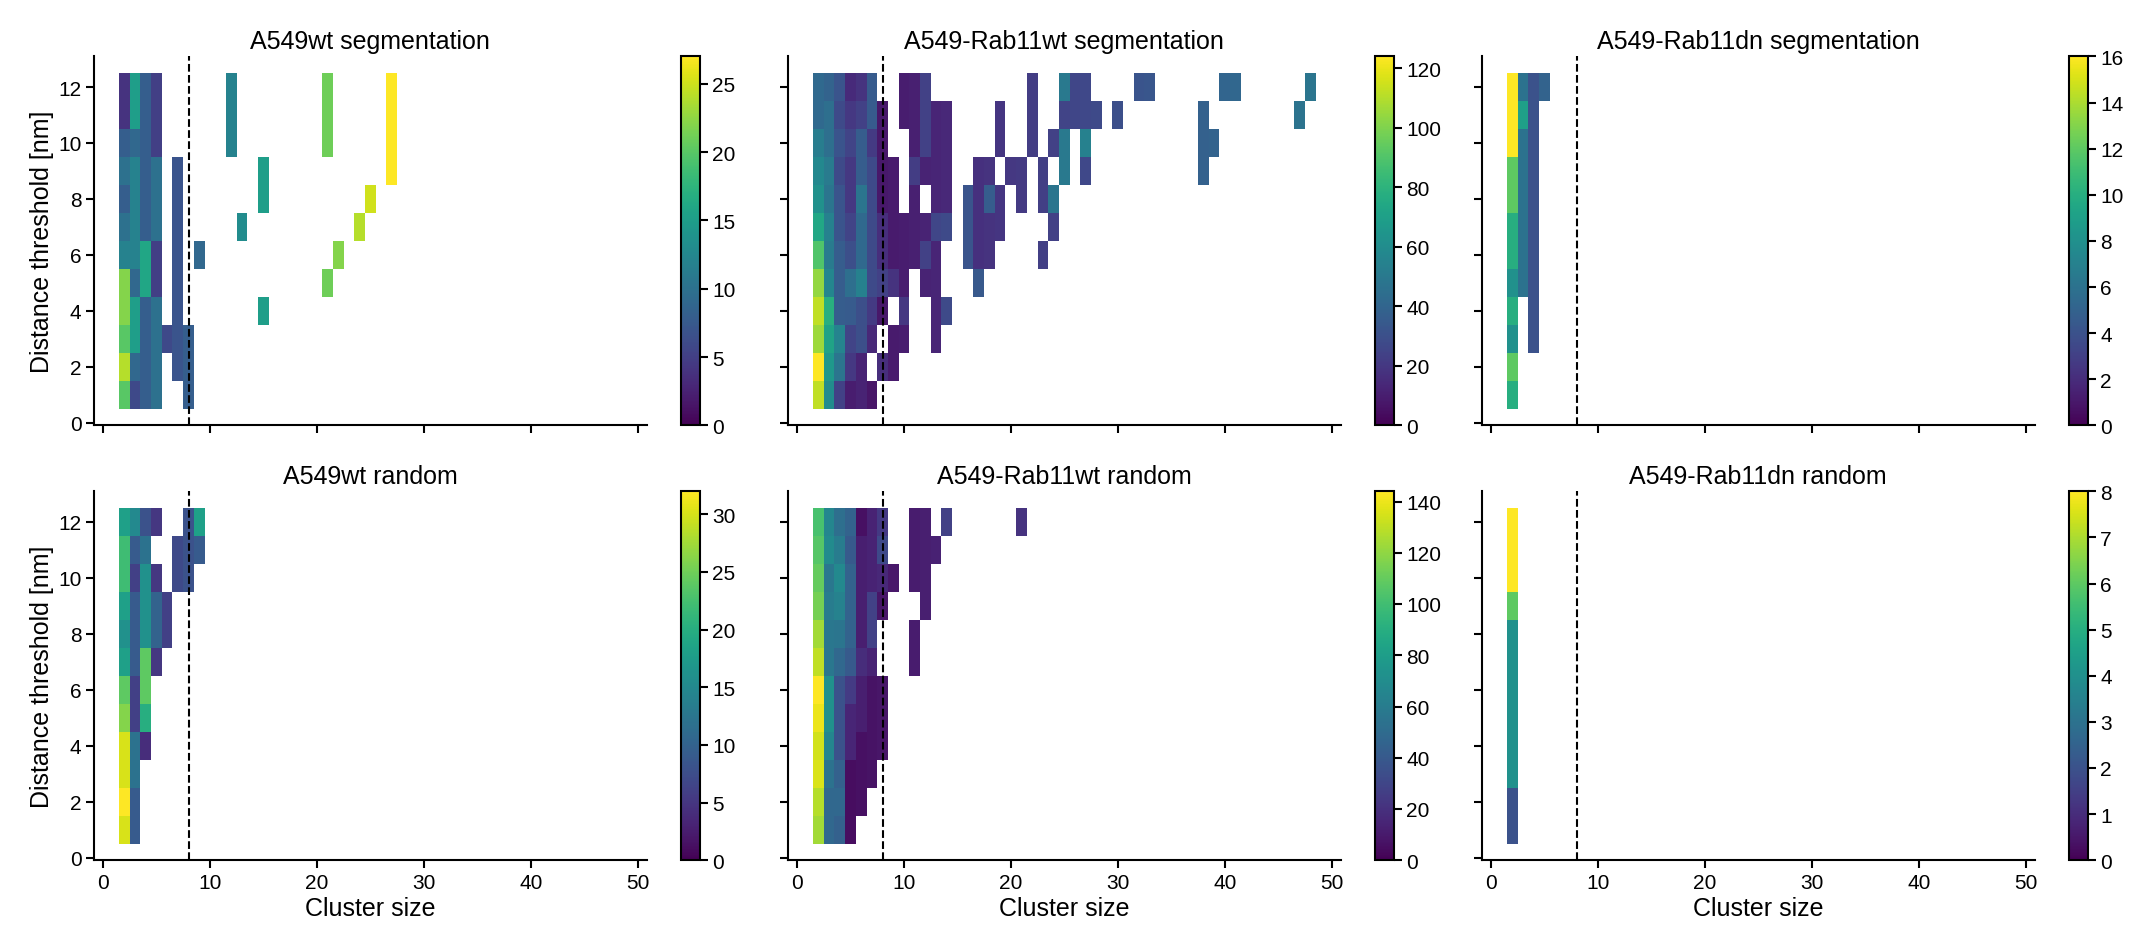

In [15]:
%matplotlib inline

g = sns.displot(
    data=cluster_size_data[(cluster_size_data.threshold > 0) & (cluster_size_data.cluster_size > 1)],
    x="cluster_size",
    y="threshold",
    kind="hist",
    discrete=True,
    cbar=True,
    cmap="viridis",
    col="cell_line",
    col_order=["A549wt", "A549-Rab11wt", "A549-Rab11dn"],
    row="matrix",
    common_norm=False,
    height=mm2in(40),
    aspect=1.55,
)

g.set_titles("{col_name} {row_name}")
g.set_xlabels("Cluster size")
g.set_ylabels("Distance threshold [nm]")

for axes in g.axes:
    for ax in axes:
        for x in [8]:
            ax.axvline(x, ls='--', lw=0.5, color="black")
            
g.savefig("cluster_heatmap.svg")

## Paper figures

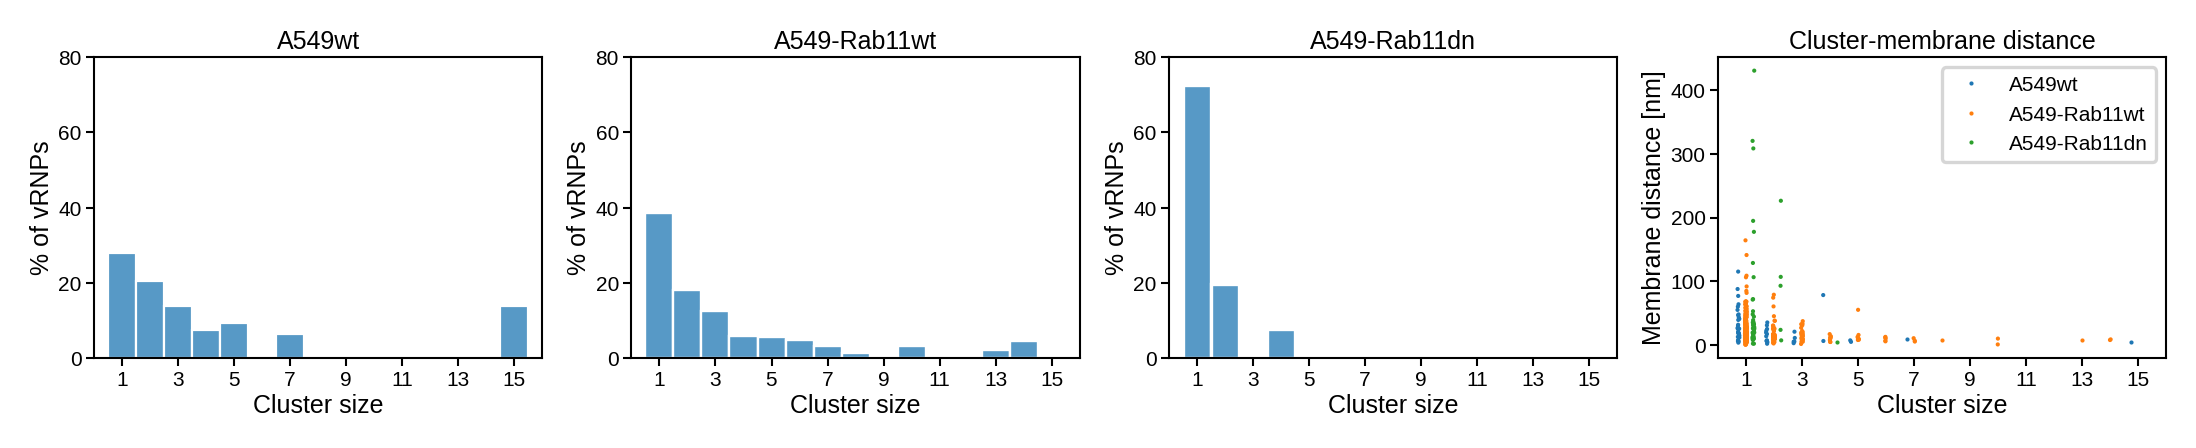

In [16]:
%matplotlib inline

fig, axes = plt.subplots(ncols=4, figsize=mm2in(183, 35))

# cluster size
thedata = lambda cell_line: cluster_size_data[
    (cluster_size_data.cluster_size > 0)
    & (cluster_size_data.threshold == cluster_distance_threshold)
    & (cluster_size_data.matrix == "segmentation")
    & (cluster_size_data.cell_line.str.fullmatch(cell_line))
]

for ax, cell_line in [
    (axes[0], "A549wt"),
    (axes[1], "A549-Rab11wt"),
    (axes[2], "A549-Rab11dn"),
]:
    sns.histplot(
        data=thedata(cell_line),
        x="cluster_size",
        stat="percent",
        discrete=True,
        ax=ax,
    )
    ax.set_title(cell_line)
    ax.set_xlabel("Cluster size")
    ax.set_ylabel("% of vRNPs")
    ax.set_ylim(0, 80)

# Cluster membrane distance
df = data.groupby(['sample', 'Cluster ID'])['vRNP membrane distance [nm]'].agg('min').reset_index()
def get_cluster_info(row):
    sample_data = data[data["sample"].str.fullmatch(row["sample"])]
    return sample_data[sample_data["Cluster ID"] == row["Cluster ID"]][["cell_line", "Cluster size"]].iloc[0]
df[["cell_line", "Cluster size"]] = df.apply(get_cluster_info, axis=1)

#fig, ax = plt.subplots(figsize=mm2in(50, 30))

sns.stripplot(
    data=df,
    y="vRNP membrane distance [nm]",
    x="Cluster size",
    hue="cell_line",
    hue_order=["A549wt", "A549-Rab11wt", "A549-Rab11dn"],
    s=1,
    dodge=True,
    native_scale=True,
    ax=axes[3],
)
axes[3].set_ylabel("Membrane distance [nm]")
axes[3].set_title("Cluster-membrane distance")
sns.move_legend(axes[3], loc="best", title="")

for ax in axes:
    ax.set_xlim(0, 16)
    xticks = list(range(1, 17, 2))
    ax.set_xticks(xticks, labels=xticks)

fig.savefig("cluster_sizes_and_distances.svg")